<h1 align=center><font size = 5>Classification of User Transaction Status on Dummy Ecommerce "The Look"</font></h1>

# Importing Library
Import library yang dibutuhkan untuk melakukan modeling

In [1]:
# Import Library untuk mengolah data
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Import Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# Import Library untuk Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Import Library untuk evaluasi
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [2]:
df = pd.read_csv("D:\Materi SI\AA FINAL PROJECT\Data Modeling 3.csv")

df

,order_id,create_at,status,user_id,gender,age,country,traffic_source,category,department,sale_price,distribution_center_id
0,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Jeans,Men,68.949997,8
1,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Swim,Men,49.990002,5
2,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Tops & Tees,Men,55.000000,3
3,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Underwear,Men,11.990000,1
4,2,2021-11-30 00:00:00,Processing,1,M,30,South Korea,Search,Sleep & Lounge,Men,42.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
180487,124508,2020-07-02 00:00:00,Returned,99997,F,50,United States,Search,Plus,Women,8.990000,1
180488,124509,2022-02-01 00:00:00,Processing,99998,F,63,South Korea,Search,Pants & Capris,Women,44.000000,3
180489,124510,2022-05-10 00:00:00,Shipped,99999,M,43,China,Search,Fashion Hoodies & Sweatshirts,Men,75.000000,4
180490,124511,2022-05-26 00:00:00,Shipped,100000,M,65,Brasil,Search,Jeans,Men,69.989998,3


# Data Exploration
Bertujuan untuk memahami dan memperoleh pengetahuan lebih banyak tentang data yang akan digunakan.

In [3]:
# Cek data type dan missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180492 entries, 0 to 180491
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                180492 non-null  int64  
 1   create_at               180492 non-null  object 
 2   status                  180492 non-null  object 
 3   user_id                 180492 non-null  int64  
 4   gender                  180492 non-null  object 
 5   age                     180492 non-null  int64  
 6   country                 180492 non-null  object 
 7   traffic_source          180492 non-null  object 
 8   category                180492 non-null  object 
 9   department              180492 non-null  object 
 10  sale_price              180492 non-null  float64
 11  distribution_center_id  180492 non-null  int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 16.5+ MB


In [4]:
# Menampilkan jumlah missing value pada masing masing kolom
print("Jumlah missing value pada masing masing kolom")
df.isnull().sum()

Jumlah missing value pada masing masing kolom


order_id                  0
create_at                 0
status                    0
user_id                   0
gender                    0
age                       0
country                   0
traffic_source            0
category                  0
department                0
sale_price                0
distribution_center_id    0
dtype: int64

Dari hasil output syntax .info() diketahui bahwa setiap kolom memiliki jumlah nilai yang sama yaitu 180505 yang artinya tidak terdapat missing value pada data. Hal tersebut juga diperkuat dengan hasil syntax .isnull() yang menunjukkan nilai masing masing kolom adalah 0. Artinya dataset yang akan dipergunakan terbebas dari permasalahan missing value.

In [5]:
# Menghitung jumlah duplicated order pada data
print('Jumlah duplicated value pada data adalah : ', df.duplicated(keep=False).sum())

Jumlah duplicated value pada data adalah :  0


Data yang digunakan untuk melakukan modeling tidak bisa mengandung duplicate value, karena akan menyebabkan terjadinya overfit pada model. Meskipun saat melakukan query dataset pada sql telah menggunakan DISTINCT pada variabel order_id, kita perlu memastikan ulang apakah masih terdapat data order yang tercatat dua kali. Hasil dari syntax .duplicate diatas menunjukkan nilai 0, artinya data transaksi tidak mengandung duplicate value.

## Mengubah data pada kolom status
Modeling yang akan dilakukan bertujuan untuk melakukan classification order yang dilakukan oleh user apakah order tersebut akan terselesaikan atau tidak terselesaikan. Target dari modeling ini adalah kolom status. Data pada kolom status akan diubah menjadi dua kategori yaitu :
1. Complete = merupakan transaksi yang terselesaikan oleh user
2. Fail = merupakan transaksi yang tidak terselesaikan / dikembalikan oleh user

Status yang tersedia pada dataset mencangkup 5 kategori yaitu 'Processing','Shipped', 'Complete', 'Cancelled', 'Returned'. Dari kelima kategori tersebut akan dikelompokkan kedalam dua target modeling dimana kondisi dan asumsi yang digunakan adalah :
1. Complete = merupakan data order dengan status 'Complete'
2. Fail =
<br>    a. Data order dengan status 'cancelled'
<br>    b. Data Order dengan status 'Returned'
<br>    c. Data order dengan status 'Shipped' dimana transaksi dibuat sudah lebih dari 31 hari
<br>    d. Data order dengan status 'Processing' dimana transaksi dibuat sudah lebih dari 31 hari

Data dengan status 'Shipped' dan 'Processing' yang memiliki waktu transaksi kurang dari 31 hari (transaksi setelah tanggal '2022-05-06') tidak akan digunakan untuk melakukan classification karena transaksi tersebut masih memiliki peluang untuk terselesaikan.

In [6]:
# Mengeluarkan data 'Shipped' dan 'Processing' setelah tanggal '2022-05-06'
df.drop(df[(df['create_at'] > '2022-05-06 00:00:00') & (df['status'] == 'Shipped')].index, inplace = True)
df.drop(df[(df['create_at'] > '2022-05-06 00:00:00') & (df['status'] == 'Processing')].index, inplace = True)

# Menampilkan dataset 
df

,order_id,create_at,status,user_id,gender,age,country,traffic_source,category,department,sale_price,distribution_center_id
0,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Jeans,Men,68.949997,8
1,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Swim,Men,49.990002,5
2,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Tops & Tees,Men,55.000000,3
3,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Underwear,Men,11.990000,1
4,2,2021-11-30 00:00:00,Processing,1,M,30,South Korea,Search,Sleep & Lounge,Men,42.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
180485,124507,2020-02-29 00:00:00,Cancelled,99997,F,50,United States,Search,Pants & Capris,Women,36.090000,10
180486,124507,2020-02-29 00:00:00,Cancelled,99997,F,50,United States,Search,Sleep & Lounge,Women,25.000000,8
180487,124508,2020-07-02 00:00:00,Returned,99997,F,50,United States,Search,Plus,Women,8.990000,1
180488,124509,2022-02-01 00:00:00,Processing,99998,F,63,South Korea,Search,Pants & Capris,Women,44.000000,3


In [7]:
# Mengganti data 'Processing','Shipped', 'Cancelled', 'Returned' menjadi 'Fail'
df.loc[df['status'] != 'Complete', 'status'] = 'Fail'


df

,order_id,create_at,status,user_id,gender,age,country,traffic_source,category,department,sale_price,distribution_center_id
0,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Jeans,Men,68.949997,8
1,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Swim,Men,49.990002,5
2,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Tops & Tees,Men,55.000000,3
3,1,2019-07-17 00:00:00,Complete,1,M,30,South Korea,Search,Underwear,Men,11.990000,1
4,2,2021-11-30 00:00:00,Fail,1,M,30,South Korea,Search,Sleep & Lounge,Men,42.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
180485,124507,2020-02-29 00:00:00,Fail,99997,F,50,United States,Search,Pants & Capris,Women,36.090000,10
180486,124507,2020-02-29 00:00:00,Fail,99997,F,50,United States,Search,Sleep & Lounge,Women,25.000000,8
180487,124508,2020-07-02 00:00:00,Fail,99997,F,50,United States,Search,Plus,Women,8.990000,1
180488,124509,2022-02-01 00:00:00,Fail,99998,F,63,South Korea,Search,Pants & Capris,Women,44.000000,3


In [8]:
# mengeluarkan kolom yang sudah tidak diperlukan
data = df.drop(['order_id', 'create_at', 'user_id', 'department'], axis=1)

data

,status,gender,age,country,traffic_source,category,sale_price,distribution_center_id
0,Complete,M,30,South Korea,Search,Jeans,68.949997,8
1,Complete,M,30,South Korea,Search,Swim,49.990002,5
2,Complete,M,30,South Korea,Search,Tops & Tees,55.000000,3
3,Complete,M,30,South Korea,Search,Underwear,11.990000,1
4,Fail,M,30,South Korea,Search,Sleep & Lounge,42.000000,2
...,...,...,...,...,...,...,...,...
180485,Fail,F,50,United States,Search,Pants & Capris,36.090000,10
180486,Fail,F,50,United States,Search,Sleep & Lounge,25.000000,8
180487,Fail,F,50,United States,Search,Plus,8.990000,1
180488,Fail,F,63,South Korea,Search,Pants & Capris,44.000000,3


Kolom 'order_id', 'create_at', dan 'user_id' dikeluarkan dari data modeling karena kolom tersebut hanya dibutuhkan pada tahap data exploration. Sedangkan kolom 'department' tidak digunakan karena kolom tersebut memilki korelasi yang kuat dengan nilai pearson correlation adalah 1 terhadap kolom gender. Sehingga kolom departemen harus dikeluarkan.

In [9]:
# Mengubah nilai kolom Status 'Fail' menjadi 0 dan 'Complete' menjadi 1
data['status'] = np.where(data['status'] == 'Fail', 0, 1)

data

,status,gender,age,country,traffic_source,category,sale_price,distribution_center_id
0,1,M,30,South Korea,Search,Jeans,68.949997,8
1,1,M,30,South Korea,Search,Swim,49.990002,5
2,1,M,30,South Korea,Search,Tops & Tees,55.000000,3
3,1,M,30,South Korea,Search,Underwear,11.990000,1
4,0,M,30,South Korea,Search,Sleep & Lounge,42.000000,2
...,...,...,...,...,...,...,...,...
180485,0,F,50,United States,Search,Pants & Capris,36.090000,10
180486,0,F,50,United States,Search,Sleep & Lounge,25.000000,8
180487,0,F,50,United States,Search,Plus,8.990000,1
180488,0,F,63,South Korea,Search,Pants & Capris,44.000000,3


In [10]:
# Pengecekan ulang data type dan missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169201 entries, 0 to 180491
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  169201 non-null  int32  
 1   gender                  169201 non-null  object 
 2   age                     169201 non-null  int64  
 3   country                 169201 non-null  object 
 4   traffic_source          169201 non-null  object 
 5   category                169201 non-null  object 
 6   sale_price              169201 non-null  float64
 7   distribution_center_id  169201 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 11.0+ MB


Untuk melakukan modeling classification, Data kategorikal yang berbentuk object harus diubah kedalam bentuk integer agar dapat dipahami oleh model

## Exploratory Data Analysis

In [11]:
# Melakukan pengecekan kembali terhadap dataset
print('Ringkasan informasi singkat Data')
data.info()

print('-------------------------------------------------')

# Menampilkan bentuk dataset
print('Jumlah baris dan kolom data')
data.shape

Ringkasan informasi singkat Data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 169201 entries, 0 to 180491
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  169201 non-null  int32  
 1   gender                  169201 non-null  object 
 2   age                     169201 non-null  int64  
 3   country                 169201 non-null  object 
 4   traffic_source          169201 non-null  object 
 5   category                169201 non-null  object 
 6   sale_price              169201 non-null  float64
 7   distribution_center_id  169201 non-null  int64  
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 11.0+ MB
-------------------------------------------------
Jumlah baris dan kolom data


(169201, 8)

Hasil dari ringkasan informasi data diatas menunjukkan bahwa dataset yang akan dipergunakan memiliki 168971 baris data pada masing masing kolomnya. Jumlah tersebut sama dengan dimensi dari data yaitu terdiri dari 168971 baris dan 8 kolom

In [12]:
# Memisahkan data numerik dan kategorik
numerical_variables = data.select_dtypes(include="number").columns.tolist()
categorical_variables = data.select_dtypes(include="object").columns.tolist()

print("Numerical variables:")
print(numerical_variables)
print('----------------------')
print("Categorical variables:")
print(categorical_variables)

Numerical variables:
['status', 'age', 'sale_price', 'distribution_center_id']
----------------------
Categorical variables:
['gender', 'country', 'traffic_source', 'category']


In [13]:
# Menampilkan descriptive statistics dari data numerik
print('Descriptive Statistics numerical_variables.')
data[numerical_variables].describe().T

Descriptive Statistics numerical_variables.


,count,mean,std,min,25%,50%,75%,max
status,169201.0,0.267605,0.442712,0.00,0.0,0.000000,1.000000,1.0
age,169201.0,41.060768,16.992998,12.00,26.0,41.000000,56.000000,70.0
sale_price,169201.0,59.835040,65.816069,0.02,24.9,39.990002,69.980003,999.0
distribution_center_id,169201.0,4.993044,2.894375,1.00,2.0,5.000000,8.000000,10.0


In [14]:
# Menampilkan descriptive statistics dari data kategorikal
print('Descriptive Statistics categorical_variables')
data[categorical_variables].describe().T

Descriptive Statistics categorical_variables


,count,unique,top,freq
gender,169201,2,M,84810
country,169201,15,China,57669
traffic_source,169201,5,Search,118605
category,169201,26,Intimates,12560


#### Berapa banyak transaksi yang berhasil ?

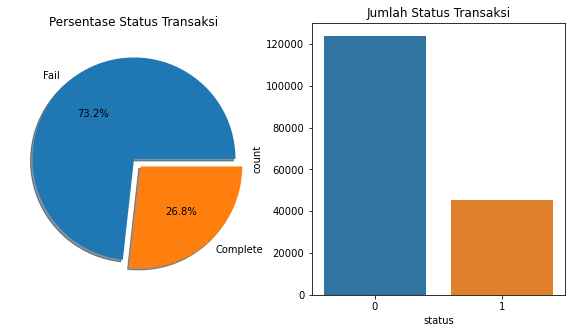

In [15]:
# Menghitung jumlah transaksi yang tergolong 'Complete' dan 'Fail'
f,ax=plt.subplots(1,2,figsize=(10,5))

df['status'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Persentase Status Transaksi')
ax[0].set_ylabel('')

sns.countplot('status',data=data,ax=ax[1])
ax[1].set_title('Jumlah Status Transaksi')

plt.show()

[Text(0.5, 1.0, 'Jumlah Status Transaksi Berdasarkan gender')]

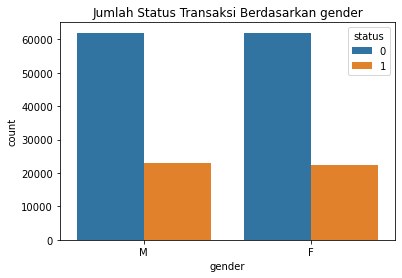

In [16]:
# Menghitung jumlah status berdasarkan gender customer

sns.countplot(
    x ='gender'
    , hue = 'status'
    , data = data
).set(title='Jumlah Status Transaksi Berdasarkan gender')

[Text(0.5, 1.0, 'Distribusi Umur customer Berdasarkan gender dan Status')]

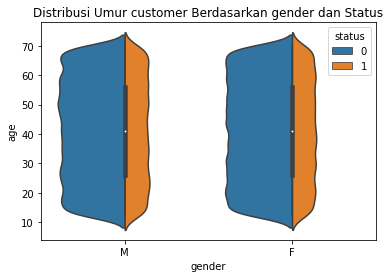

In [17]:
# Distribusi umur customer berdasarkan gender dan status transaksi

sns.violinplot(
    x='gender'
    , y='age'
    , hue='status'
    , data=data
    , split=True
    , scale="count"
).set(title='Distribusi Umur customer Berdasarkan gender dan Status')

Hasil violinplot diatas menunjukkan bahwa umur user terdistribusi merata dimana antara user laki laki dan perempuan memiliki kondisi yang relatif sama

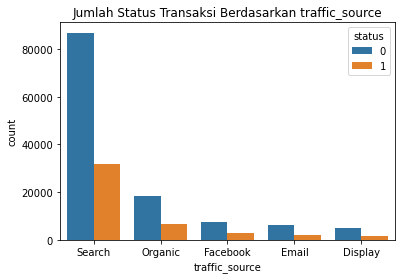

In [18]:
# Menampilkan jumlah Status Transaksi Berdasarkan Traffic Source

# Membuat order untuk mengurutkan visualisasi
traffic_source_order = data.traffic_source.value_counts().index

plt.figure(figsize=(6, 4))
sns.countplot(
    x='traffic_source',
    hue = 'status',
    data=data,
    order=traffic_source_order
).set(title='Jumlah Status Transaksi Berdasarkan traffic_source')

plt.grid(False)
plt.show()

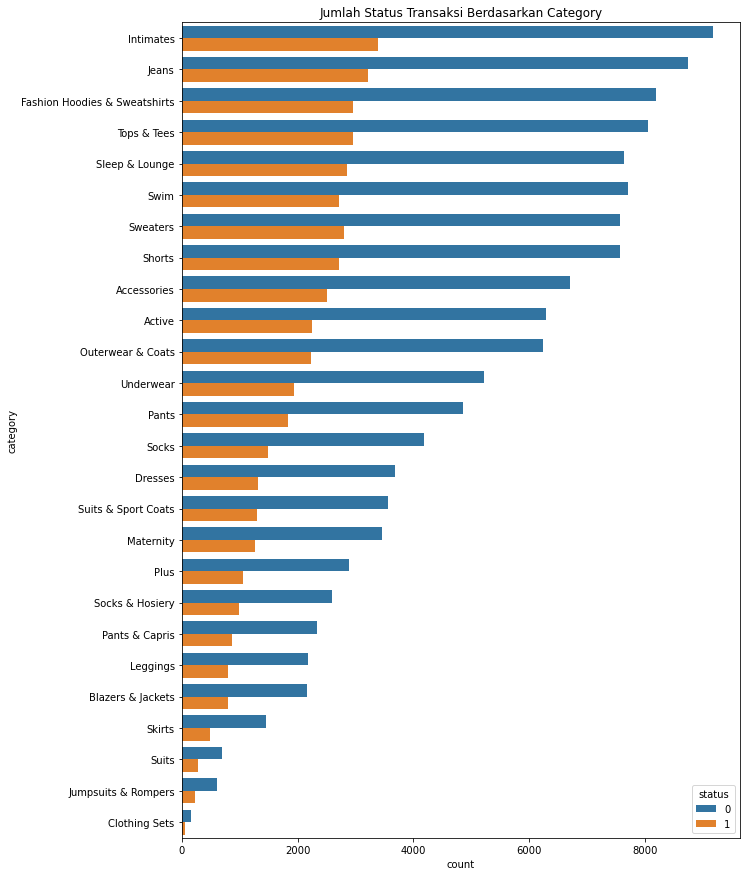

In [19]:
# Menampilkan jumlah Status Transaksi Berdasarkan Category

# Membuat order untuk mengurutkan visualisasi
category_order = data.category.value_counts().index

plt.figure(figsize=(10, 15))
sns.countplot(
    y="category",
    hue = 'status',
    data=data,
    order=category_order
).set(title='Jumlah Status Transaksi Berdasarkan Category')
plt.grid(False)
plt.show()

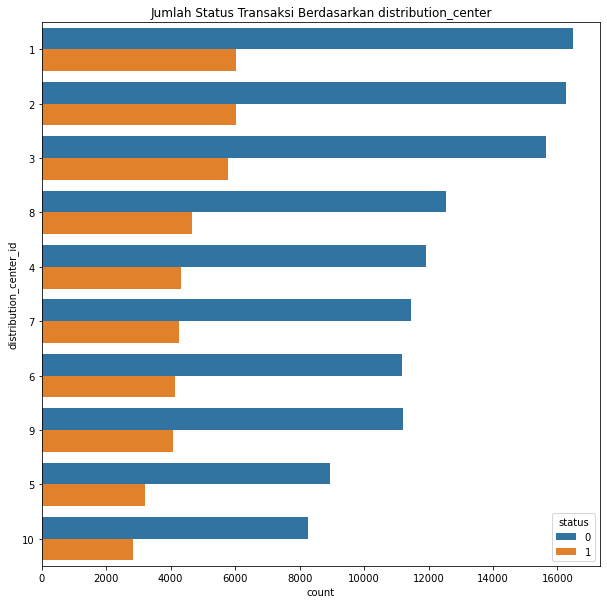

In [20]:
# Menampilkan jumlah Status Transaksi Berdasarkan Distribution Center

# Membuat order untuk mengurutkan visualisasi
distribution_center_order = data.distribution_center_id.value_counts().index

plt.figure(figsize=(10, 10))
sns.countplot(
    y="distribution_center_id"
    , hue = 'status'
    , data=data
    , order=distribution_center_order
).set(title='Jumlah Status Transaksi Berdasarkan distribution_center')
plt.grid(False)
plt.show()

## Data Preparation

In [21]:
# Mengubah value pada kolom yang berbentuk object kedalam bentuk integer
label_encoder = preprocessing.LabelEncoder()
data['gender']= label_encoder.fit_transform(data['gender'])
data['country']= label_encoder.fit_transform(data['country'])
data['traffic_source']= label_encoder.fit_transform(data['traffic_source'])
data['category']= label_encoder.fit_transform(data['category'])

data

,status,gender,age,country,traffic_source,category,sale_price,distribution_center_id
0,1,1,30,11,4,7,68.949997,8
1,1,1,30,11,4,23,49.990002,5
2,1,1,30,11,4,24,55.000000,3
3,1,1,30,11,4,25,11.990000,1
4,0,1,30,11,4,17,42.000000,2
...,...,...,...,...,...,...,...,...
180485,0,0,50,14,4,13,36.090000,10
180486,0,0,50,14,4,17,25.000000,8
180487,0,0,50,14,4,14,8.990000,1
180488,0,0,63,11,4,13,44.000000,3


In [22]:
# Scaling data menggunakan StandardScaler
scaler = StandardScaler()
scaler.fit(data)

data_scaled = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

data_scaled

,status,gender,age,country,traffic_source,category,sale_price,distribution_center_id
0,1.654344,0.997527,-0.650903,0.757834,0.541449,-0.734579,0.138492,1.038900
1,1.654344,0.997527,-0.650903,0.757834,0.541449,1.288855,-0.149585,0.002403
2,1.654344,0.997527,-0.650903,0.757834,0.541449,1.415320,-0.073463,-0.688594
3,1.654344,0.997527,-0.650903,0.757834,0.541449,1.541785,-0.726953,-1.379592
4,-0.604469,0.997527,-0.650903,0.757834,0.541449,0.530068,-0.270984,-1.034093
...,...,...,...,...,...,...,...,...
169196,-0.604469,-1.002479,0.526055,1.410777,0.541449,0.024209,-0.360780,1.729897
169197,-0.604469,-1.002479,0.526055,1.410777,0.541449,0.530068,-0.529280,1.038900
169198,-0.604469,-1.002479,0.526055,1.410777,0.541449,0.150674,-0.772535,-1.379592
169199,-0.604469,-1.002479,1.291079,0.757834,0.541449,0.024209,-0.240596,-0.688594


Hasil dari StandardScaler diatas mengubah data yang ada agar memiliki jarak antar data yang tidak terpaut jauh. Hasil dari StandardScaler membuat nilai dari data menjadi float, termasuk nilai dari label/target. Pada Model classification, target / label tidak bisa bernilai continuous / float maka kita perlu mengubah kembali nilai label kedalam bentuk integer 1 dan 0 

In [23]:
# Mengembalikan nilai label pada kolom status
data_scaled['status']= label_encoder.fit_transform(data_scaled['status'])

data_scaled

,status,gender,age,country,traffic_source,category,sale_price,distribution_center_id
0,1,0.997527,-0.650903,0.757834,0.541449,-0.734579,0.138492,1.038900
1,1,0.997527,-0.650903,0.757834,0.541449,1.288855,-0.149585,0.002403
2,1,0.997527,-0.650903,0.757834,0.541449,1.415320,-0.073463,-0.688594
3,1,0.997527,-0.650903,0.757834,0.541449,1.541785,-0.726953,-1.379592
4,0,0.997527,-0.650903,0.757834,0.541449,0.530068,-0.270984,-1.034093
...,...,...,...,...,...,...,...,...
169196,0,-1.002479,0.526055,1.410777,0.541449,0.024209,-0.360780,1.729897
169197,0,-1.002479,0.526055,1.410777,0.541449,0.530068,-0.529280,1.038900
169198,0,-1.002479,0.526055,1.410777,0.541449,0.150674,-0.772535,-1.379592
169199,0,-1.002479,1.291079,0.757834,0.541449,0.024209,-0.240596,-0.688594


In [24]:
# Mengecek kembali data type dan missing values
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169201 entries, 0 to 169200
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   status                  169201 non-null  int64  
 1   gender                  169201 non-null  float64
 2   age                     169201 non-null  float64
 3   country                 169201 non-null  float64
 4   traffic_source          169201 non-null  float64
 5   category                169201 non-null  float64
 6   sale_price              169201 non-null  float64
 7   distribution_center_id  169201 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 10.3 MB


# Splitting data
Modeling classification yang akan dilakukan menggunakan kolom 'status' menjadi label / target / y dan kolom 'gender', 'age', 'country', 'traffic_source', 'category', 'sale_price', 'distribution_center_id' sebagai variabel / feature / X.

Data yang ada akan dibagi menjadi data training, data development, dan data test dengan komposisi :
1. Data training = 90%
2. Data development = 5%
3. Data test = 5%

In [25]:
# Memisahkan antara Target/Label dengan Variabel/Features
y = data_scaled['status']
X = data_scaled[['gender', 'age', 'country', 'traffic_source', 'category', 'sale_price', 'distribution_center_id']]

In [26]:
# Data splitting
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.1, stratify=y, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=42)

print(f"training size: {X_train.shape[0]} ({100*X_train.shape[0] / X.shape[0]:.3f}%)")
print(f"dev size: {X_dev.shape[0]} ({100*X_dev.shape[0] / X.shape[0]:.3f}%)")
print(f"test size: {X_test.shape[0]} ({100*X_test.shape[0] / X.shape[0]:.3f}%)")

training size: 152280 (89.999%)
dev size: 8460 (5.000%)
test size: 8461 (5.001%)


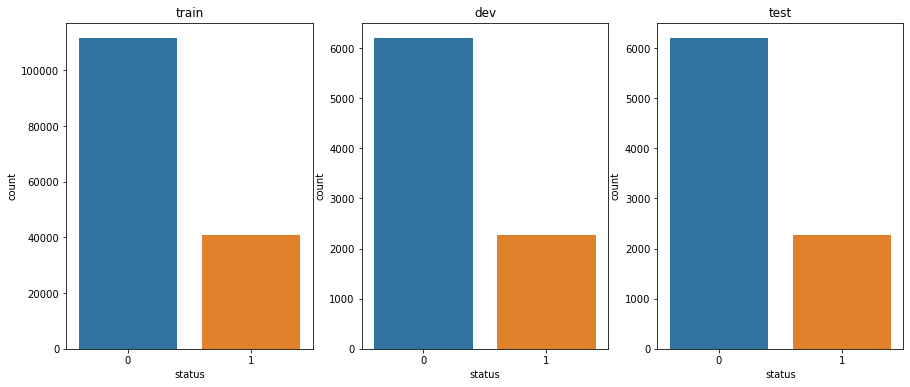

In [27]:
# Melihat distribusi data

fig, axis = plt.subplots(1, 3, figsize=(15, 6))
for idx, label in enumerate([
    (y_train, "train"), (y_dev, "dev"), (y_test, "test")
]):
    sns.countplot(x=label[0], ax=axis[idx])
    axis[idx].set_title(label[1])
    axis[idx].grid(False)
plt.show()

# Model Development
Menurut Andreas C. Müller and Sarah Guido pada Introduction to Machine Learning with Python (2017) terdapat beberapa model yang dapat digunakan untuk melakukan classification. Namun model yang dapat digunakan pada kondisi data yang digunakan meliputi :
1. LogisticRegression
2. RandomForestClassifier
3. DecisionTreeClassifier
4. GradientBoostingClassifier

Dari Keempat model tersebut akan dicoba masing masing pada data dan akan dievaluasi berdasarkan hasil nilai akurasi terbaik.

## LogisticRegression C=1

In [28]:
# Memanggil function Logistic Regression senagai logreg
logreg = LogisticRegression()

# Menerapkan model Logistic Regression menggunakan data training
logreg.fit(X_train, y_train)

LogisticRegression()

In [29]:
# Melakukan prediksi dari model Logistic Regression yang sudah dibuat menggunakan data traning, development, dan test
preds_train_logreg = logreg.predict(X_train)
preds_dev_logreg = logreg.predict(X_dev)
preds_test_logreg = logreg.predict(X_test)

In [30]:
# menampilkan hasi akurasi prediksi menggunakan model Logistic Regression
print ("Accuracy Training : ", accuracy_score(y_train, preds_train_logreg))
print ("Accuracy development : ", accuracy_score(y_dev, preds_dev_logreg))
print ("Accuracy test : ", accuracy_score(y_test, preds_test_logreg))

Accuracy Training :  0.7323942737063305
Accuracy development :  0.7323877068557919
Accuracy test :  0.732419335775913


In [31]:
# Menampilkan nilai koefisien regresi logistik
odds = np.exp(logreg.coef_[0])
pd.DataFrame(odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

,coef
gender,1.014786
traffic_source,1.003136
country,1.002725
category,0.999233
sale_price,0.996843
age,0.989745
distribution_center_id,0.988238


## RandomForestClassifier

In [21]:
forest = RandomForestClassifier(n_estimators=100, random_state=5)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=5)

In [22]:
preds_train_forest = forest.predict(X_train)
preds_dev_forest = forest.predict(X_dev)
preds_test_forest = forest.predict(X_test)

In [23]:
print ("Accuracy Training : ", accuracy_score(y_train, preds_train_forest))
print ("Accuracy development : ", accuracy_score(y_dev, preds_dev_forest))
print ("Accuracy test : ", accuracy_score(y_test, preds_test_forest))

Accuracy Training :  0.9942802731809824
Accuracy development :  0.7017730496453901
Accuracy test :  0.7035811369814443


## DecisionTreeClassifier

In [24]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [25]:
preds_train_tree = tree.predict(X_train)
preds_dev_tree = tree.predict(X_dev)
preds_test_tree = tree.predict(X_test)

In [26]:
print ("Accuracy Training : ", accuracy_score(y_train, preds_train_tree))
print ("Accuracy development : ", accuracy_score(y_dev, preds_dev_tree))
print ("Accuracy test : ", accuracy_score(y_test, preds_test_tree))

Accuracy Training :  0.9943131074336748
Accuracy development :  0.6080378250591016
Accuracy test :  0.5946105661269353


## DecisionTreeClassifier 2

In [27]:
tree2 = DecisionTreeClassifier(max_depth=6, random_state=0)
tree2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

In [28]:
preds_train_tree2 = tree2.predict(X_train)
preds_dev_tree2 = tree2.predict(X_dev)
preds_test_tree2 = tree2.predict(X_test)

In [29]:
print ("Accuracy Training : ", accuracy_score(y_train, preds_train_tree2))
print ("Accuracy development : ", accuracy_score(y_dev, preds_dev_tree2))
print ("Accuracy test : ", accuracy_score(y_test, preds_test_tree2))

Accuracy Training :  0.7324402416600998
Accuracy development :  0.7323877068557919
Accuracy test :  0.732419335775913


## GradientBoostingClassifier

In [30]:
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [31]:
preds_train_gbrt = gbrt.predict(X_train)
preds_dev_gbrt = gbrt.predict(X_dev)
preds_test_gbrt = gbrt.predict(X_test)

In [32]:
print ("Accuracy Training : ", accuracy_score(y_train, preds_train_gbrt))
print ("Accuracy development : ", accuracy_score(y_dev, preds_dev_gbrt))
print ("Accuracy test : ", accuracy_score(y_test, preds_test_gbrt))

Accuracy Training :  0.7324468085106383
Accuracy development :  0.7322695035460993
Accuracy test :  0.7323011464365914


Hasil diatas menunjukkan bahwa hasil akurasi test terbaik diberikan pada hasil modeling :
1. LogisticRegression
2. DecisionTreeClassifier
3. GradientBoostingClassifier

Hasil akurasidari ketiganya sama yaitu 
1. Accuracy Training :  0.7324730759127922
2. Accuracy development :  0.7323877068557919
3. Accuracy test :  0.732419335775913


Karena ketiga model tersebut memberikan hasil akurasi yang sama maka akan model DecisionTreeClassifier akan digunakan untuk dievaluasi dan meninjau  komponen yang mempengaruhi transaction status customer.

## Model Evaluation

Default model performance on training set..
              precision    recall  f1-score   support

           0       0.73      1.00      0.85    111529
           1       0.82      0.00      0.00     40751

    accuracy                           0.73    152280
   macro avg       0.78      0.50      0.42    152280
weighted avg       0.76      0.73      0.62    152280



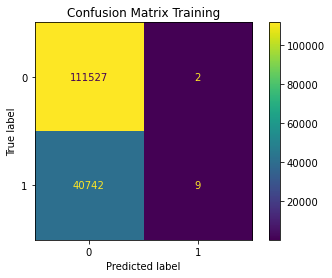

In [33]:
print("Default model performance on training set..")
print(classification_report(y_train, preds_train_tree2))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, preds_train_tree2)
plt.title("Confusion Matrix Training")
plt.grid(False)
plt.show()

Default model performance on dev set...
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      6196
           1       0.00      0.00      0.00      2264

    accuracy                           0.73      8460
   macro avg       0.37      0.50      0.42      8460
weighted avg       0.54      0.73      0.62      8460



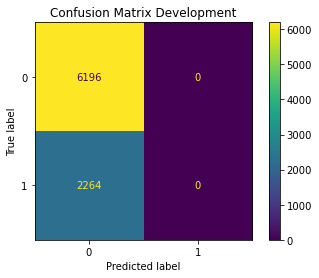

In [34]:
print("Default model performance on dev set...")
print(classification_report(y_dev, preds_dev_tree2))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev_tree2)
plt.title("Confusion Matrix Development")
plt.grid(False)
plt.show()

Default model performance on test set...
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      6197
           1       0.00      0.00      0.00      2264

    accuracy                           0.73      8461
   macro avg       0.37      0.50      0.42      8461
weighted avg       0.54      0.73      0.62      8461



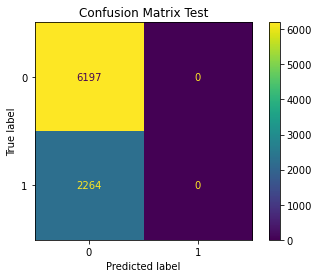

In [35]:
print("Default model performance on test set...")
print(classification_report(y_test, preds_test_tree2))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_test_tree2)
plt.title("Confusion Matrix Test")
plt.grid(False)
plt.show()

## Rendahnya Accuracy pada Model
Hasil dari confussion Matrix Test dan accuracy test model menunjukkan hasil yang kurang optimal. untuk meningkatkan performa model perlu dilakukan evaluasi penyebab rendahnya akurasi model yang dibuat. Evaluasi tersebut menggunakan learning curve dari sklearn untuk mengetahui performa model yang dibuat.

In [84]:
 train_sizes_tree2, train_scores_tree2, test_scores_tree2 = learning_curve(DecisionTreeClassifier(max_depth=6, random_state=0)
                                                                           , X
                                                                           , y
                                                                           , cv=10
                                                                           , scoring='accuracy'
                                                                           , n_jobs=-1
                                                                           , train_sizes=np.linspace(0.01, 1.0, 50))

In [85]:
train_mean_tree2 = np.mean(train_scores_tree2, axis=1)
train_std_tree2 = np.std(train_scores_tree2, axis=1)

test_mean_tree2 = np.mean(test_scores_tree2, axis=1)
test_std_tree2 = np.std(test_scores_tree2, axis=1)

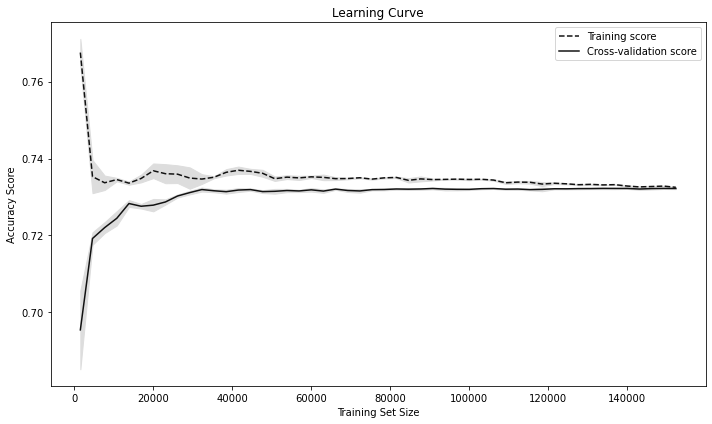

In [86]:
plt.subplots(1, figsize=(10,6))
plt.plot(train_sizes_tree2, train_mean_tree2, '--', color="#111111",  label="Training score")
plt.plot(train_sizes_tree2, test_mean_tree2, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes_tree2, train_mean_tree2 - train_std_tree2, train_mean_tree2 + train_std_tree2, color="#DDDDDD")
plt.fill_between(train_sizes_tree2, test_mean_tree2 - test_std_tree2, test_mean_tree2 + test_std_tree2, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Penyebab rendahnya Akurasi pada model dijelaskan dari hasil plot Learning Curve. Hasil dari Learning curve menunjukkan bahwa penambahan data tidak memberikan kenaikan akurasi tetapi malah menyebabkan terjadinya high bias pada hasil modeling. Solusinya berdasarkan *Bias-Variance trade-off* mengharuskan dilakukan penambahan variabel yang relevan terhadap label agar bias pada data dapat berkurang. Akan tetapi dalam data yang tersedia sudah tidak memiliki variabel yang berkaitan dengan status transaksi customer.

## Interpretasi Hasil

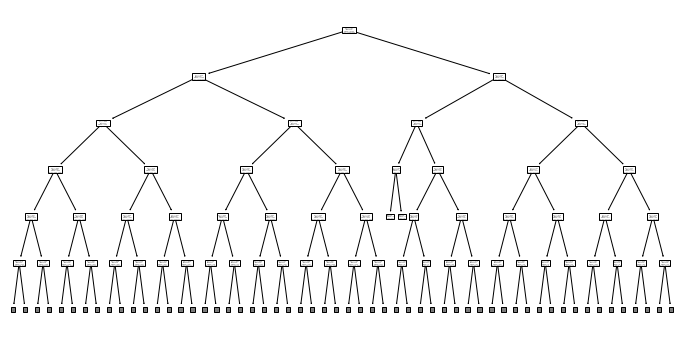

In [36]:
plt.figure(figsize=(12, 6))
plot_tree(tree2, max_depth=5)
plt.show()

Hasil visualisasi decision tree diatas cukup sulit untuk diinterpretasikan. Maka untuk mempermudah interpretasi dapat dilakukan plotting feature importen dari model

[Text(0.5, 1.0, 'Feature Importances')]

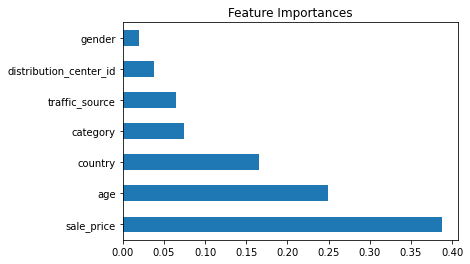

In [16]:
(pd.Series(tree2.feature_importances_, index=X.columns)
   .nlargest(8)
   .plot(kind='barh')
   .set(title='Feature Importances') )

Meskipun hasil akurasi model yang cukup rendah yaitu 73%, namun dari model tersebut kita dapat mengambil kesimpulan bahwa komponen variabel yang memberikan pengaruh terbesar terhadap status transaction customer adalah sale_price, age, dan country. Hal tersebut juga mampu menjawab pertanyaan bisnis bahwa feature yang memberikan pengaruh terbesar terhadap status transaksi adalah harga barang itu sendiri